In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import csv
import os
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(1337)

# Download modules

In [3]:
if not os.path.exists('checkpoint'):
    os.makedirs('checkpoint')

url = f"https://raw.githubusercontent.com/adamoosya/182Proj/main/hyperparameters.py"
!wget --no-cache --backups=1 {url}
from hyperparameters import BATCH_SIZE, BLOCK_SIZE, MAX_ITERS, EVAL_INTERVAL, LEARNING_RATE, EVAL_ITERS, N_EMBD, N_HEAD, N_LAYER, DROPOUT, DEVICE

url = f"https://raw.githubusercontent.com/adamoosya/182Proj/main/tokenizer.py"
!wget --no-cache --backups=1 {url}
from tokenizer import tokenize, detokenize, IS_TO_TOKEN, AS_TOKEN, END_TOKEN, VOCAB_SIZE, CHAR_TO_TOKEN, TOKEN_TO_CHAR

url = f"https://raw.githubusercontent.com/adamoosya/182Proj/main/dataloader.py"
!wget --no-cache --backups=1 {url}
from dataloader import get_context_test, get_context_example, get_batch

url = f"https://raw.githubusercontent.com/adamoosya/182Proj/main/model.py"
!wget --no-cache --backups=1 {url}
from model import estimate_loss, GPTLanguageModel

--2025-04-23 03:34:50--  https://raw.githubusercontent.com/adamoosya/182Proj/main/hyperparameters.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343 [text/plain]
Failed to rename hyperparameters.py to hyperparameters.py.1: (2) No such file or directory
Saving to: ‘hyperparameters.py’

hyperparameters.py  100%[===================>]     343  --.-KB/s    in 0s      

2025-04-23 03:34:50 (32.2 MB/s) - ‘hyperparameters.py’ saved [343/343]

--2025-04-23 03:34:51--  https://raw.githubusercontent.com/adamoosya/182Proj/main/tokenizer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP 

In [4]:
DEVICE

'cuda'

# Download data

In [5]:
DATA: dict[str, list[str]] = {
    "singular_to_plural": [],
    "present_tense_to_past_tense": [],
    "base_case_to_third_person_singular": [],
    "singular_possessive_to_plural_possessive": [],
    "comparative_adjective_to_superlative_adjective": [],
    "verb_to_progressive_verb": [],
    "verb_to_derived_agentive": [],
    "base_case_to_diminuitive": [],
}

TRAIN_DATA: dict[str, list[str]] = {
    "singular_to_plural": [],
    "present_tense_to_past_tense": [],
    "base_case_to_third_person_singular": [],
    "singular_possessive_to_plural_possessive": [],
}

VAL_DATA: dict[str, list[str]] = {
    "singular_to_plural": [],
    "present_tense_to_past_tense": [],
    "base_case_to_third_person_singular": [],
    "singular_possessive_to_plural_possessive": [],
    "comparative_adjective_to_superlative_adjective": [],
    "verb_to_progressive_verb": [],
    "verb_to_derived_agentive": [],
    "base_case_to_diminuitive": [],
}

In [6]:
csv_filepaths = [category + ".csv" for category in DATA.keys()]
for csv_filepath in csv_filepaths:
  url = f"https://raw.githubusercontent.com/adamoosya/182Proj/main/data/{csv_filepath}"
  !wget --no-cache --backups=1 {url}

--2025-04-23 03:34:51--  https://raw.githubusercontent.com/adamoosya/182Proj/main/data/singular_to_plural.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147270 (144K) [text/plain]
Failed to rename singular_to_plural.csv to singular_to_plural.csv.1: (2) No such file or directory
Saving to: ‘singular_to_plural.csv’

singular_to_plural. 100%[===================>] 143.82K  --.-KB/s    in 0.03s   

2025-04-23 03:34:51 (4.42 MB/s) - ‘singular_to_plural.csv’ saved [147270/147270]

--2025-04-23 03:34:51--  https://raw.githubusercontent.com/adamoosya/182Proj/main/data/present_tense_to_past_tense.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (ra

In [7]:
for category in DATA.keys():
  csv_filepath = category + ".csv"
  with open(csv_filepath, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    word_pairs = set()
    for row in reader:
      if len(row) >= 2:  # Ensure there are at least two elements in the row
        word1, word2 = row[0], row[1]
        if all(c in CHAR_TO_TOKEN for c in word1) and all(c in CHAR_TO_TOKEN for c in word2):
          word_pairs.add((word1, word2))
    word_pairs = list(word_pairs)
    DATA[category] = word_pairs

In [8]:
train_categories = ["singular_to_plural", "present_tense_to_past_tense", "base_case_to_third_person_singular", "singular_possessive_to_plural_possessive"]

for category, word_pairs in DATA.items():
  if category in train_categories:
    split_index = int(0.9 * len(word_pairs))
    TRAIN_DATA[category] = word_pairs[:split_index]
    VAL_DATA[category] = word_pairs[split_index:]
  else:
    VAL_DATA[category] = word_pairs

# Run model

In [9]:
losses = {
    'train': {
        'singular_to_plural': [],
        'present_tense_to_past_tense': [],
        'base_case_to_third_person_singular': [],
        'singular_possessive_to_plural_possessive': [],
        None: [],
    },
    'val': {
        "singular_to_plural": [],
        "present_tense_to_past_tense": [],
        "base_case_to_third_person_singular": [],
        "singular_possessive_to_plural_possessive": [],
        "comparative_adjective_to_superlative_adjective": [],
        "verb_to_progressive_verb": [],
        "verb_to_derived_agentive": [],
        "base_case_to_diminuitive": [],
        None: [],
    }
}
correctness = {
    'train': {
        'singular_to_plural': [],
        'present_tense_to_past_tense': [],
        'base_case_to_third_person_singular': [],
        'singular_possessive_to_plural_possessive': [],
        None: [],
    },
    'val': {
        "singular_to_plural": [],
        "present_tense_to_past_tense": [],
        "base_case_to_third_person_singular": [],
        "singular_possessive_to_plural_possessive": [],
        "comparative_adjective_to_superlative_adjective": [],
        "verb_to_progressive_verb": [],
        "verb_to_derived_agentive": [],
        "base_case_to_diminuitive": [],
        None: [],
    }
}

In [10]:
def evaluate(model, dataset, category=None, num_to_evaluate=100):
    correct = 0
    total = 0
    for _ in range(num_to_evaluate):
        context, target = get_context_test(dataset, category=category)
        if model.test(context, target):
            correct += 1
        total += 1
    return correct / total

In [11]:
model = GPTLanguageModel()
model = model.to(DEVICE)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

10.713631 M parameters


In [12]:
for iter in range(MAX_ITERS):

    # every once in a while evaluate the loss on train and val sets
    if iter % EVAL_INTERVAL == 0 or iter == MAX_ITERS - 1:

        for dataset, dataset_name in zip([TRAIN_DATA, VAL_DATA], ['train', 'val']):

            for category in dataset.keys():
                category_name = category if category else 'None'

                # Store the loss over each category
                loss = estimate_loss(model, dataset, category=category)
                print(f"Epoch: {iter}, Data: {dataset_name}, Category: {category_name}, Loss: {loss.item():.4f}")
                losses[dataset_name][category].append(loss)

                # Store the score over each category
                score = evaluate(model, dataset, category=category)
                print(f"Epoch: {iter}, Data: {dataset_name}, Category: {category_name}, Score: {score:.4f}")
                correctness[dataset_name][category].append(score)

                #Checkpoint the model
                torch.save(model.state_dict(), f'checkpoint/checkpoint_at_epoch_{iter}.pth')

    # sample a batch of data
    xb, yb, mask = get_batch(TRAIN_DATA)

    # evaluate the loss
    logits, loss = model(xb, yb, mask)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

Epoch: 0, Data: train, Category: singular_to_plural, Loss: 3.6209
Epoch: 0, Data: train, Category: singular_to_plural, Score: 0.0000
0: train singular_to_plural: 0.0000
Epoch: 0, Data: train, Category: present_tense_to_past_tense, Loss: 3.6674
Epoch: 0, Data: train, Category: present_tense_to_past_tense, Score: 0.0000
0: train present_tense_to_past_tense: 0.0000
Epoch: 0, Data: train, Category: base_case_to_third_person_singular, Loss: 3.6519
Epoch: 0, Data: train, Category: base_case_to_third_person_singular, Score: 0.0000
0: train base_case_to_third_person_singular: 0.0000
Epoch: 0, Data: train, Category: singular_possessive_to_plural_possessive, Loss: 3.6853
Epoch: 0, Data: train, Category: singular_possessive_to_plural_possessive, Score: 0.0000
0: train singular_possessive_to_plural_possessive: 0.0000
Epoch: 0, Data: val, Category: singular_to_plural, Loss: 3.6189
Epoch: 0, Data: val, Category: singular_to_plural, Score: 0.0000
0: val singular_to_plural: 0.0000
Epoch: 0, Data: val,

# Statistics

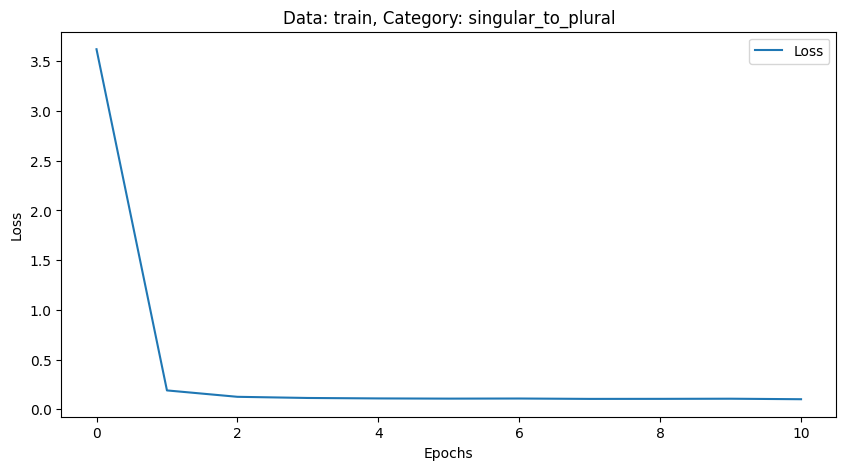

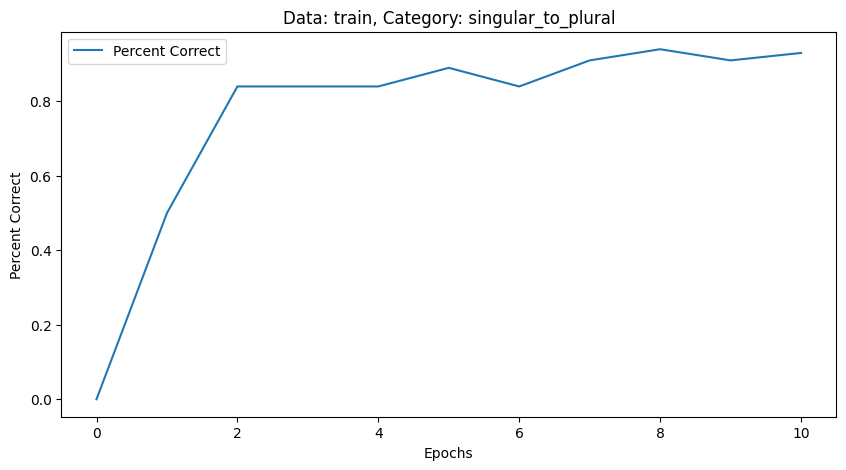

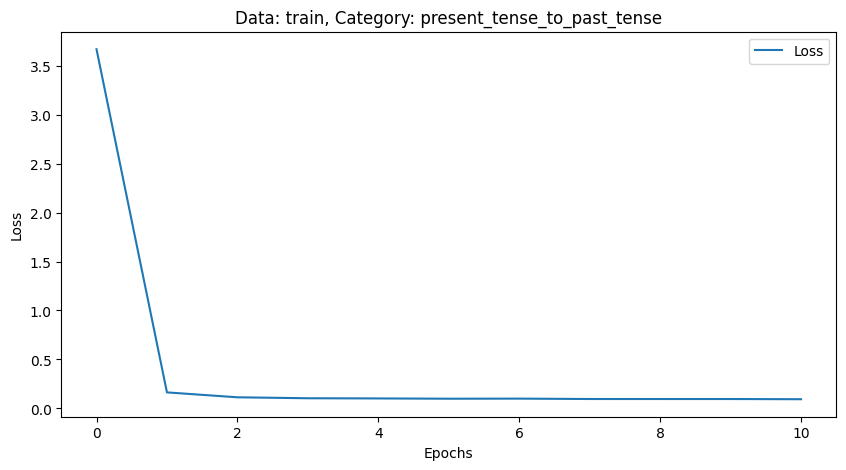

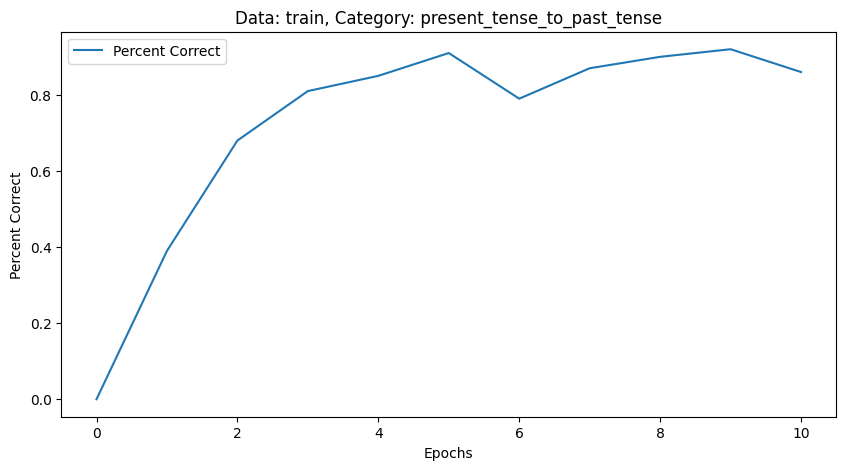

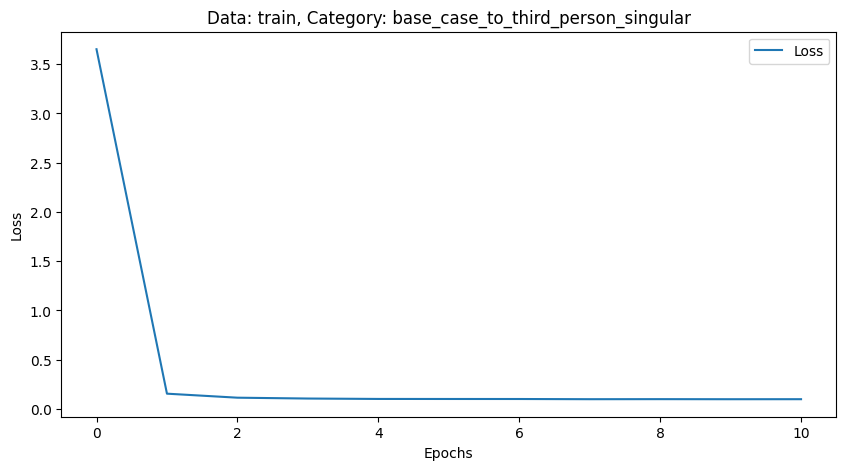

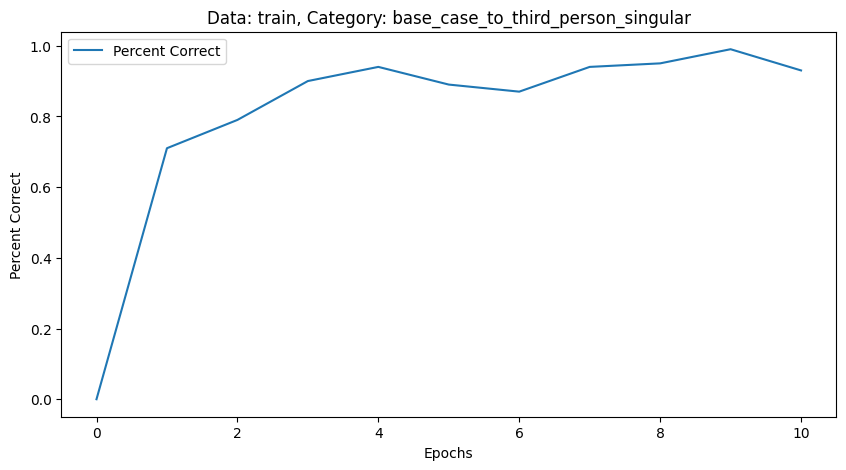

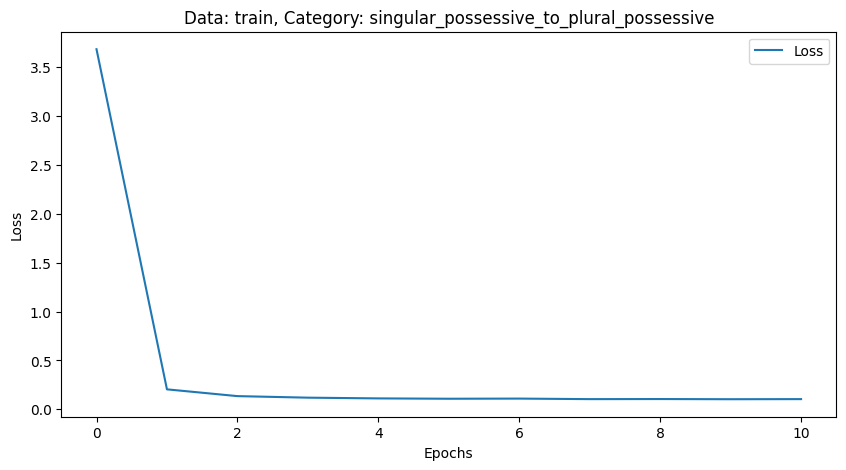

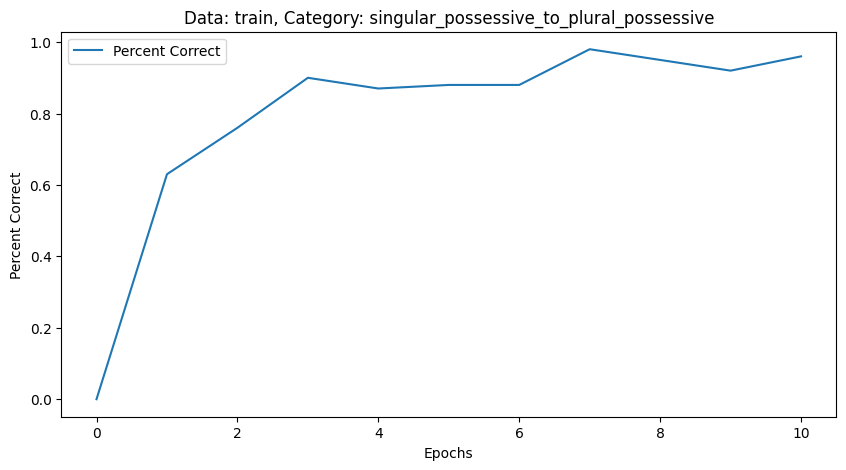

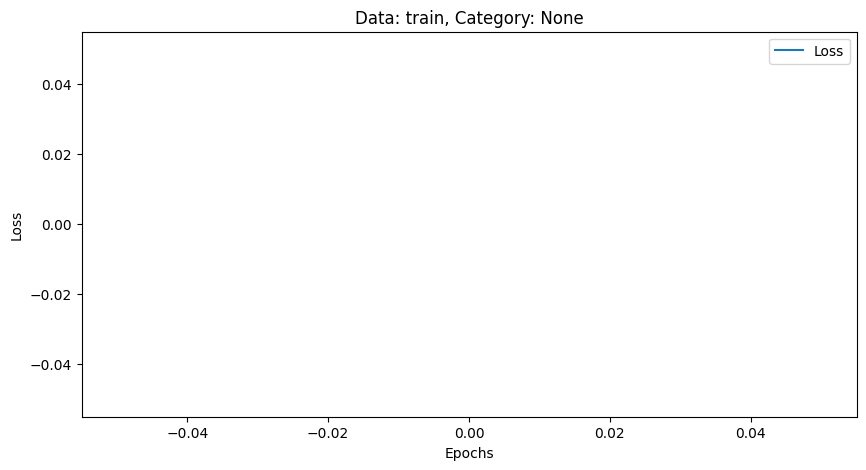

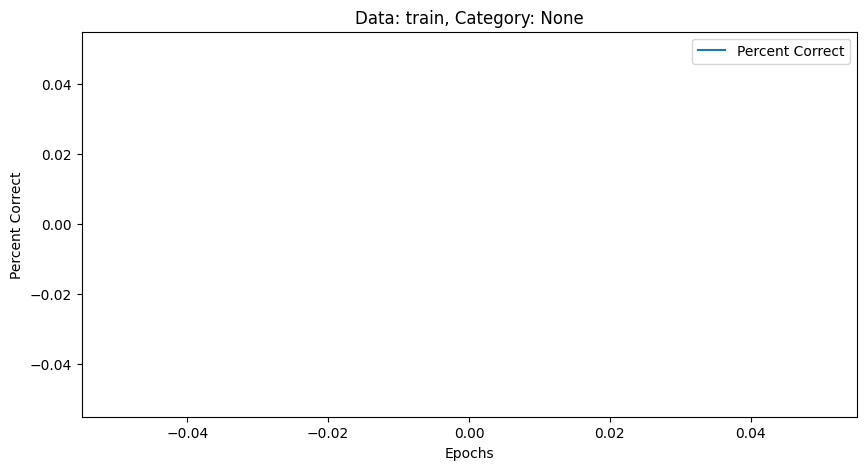

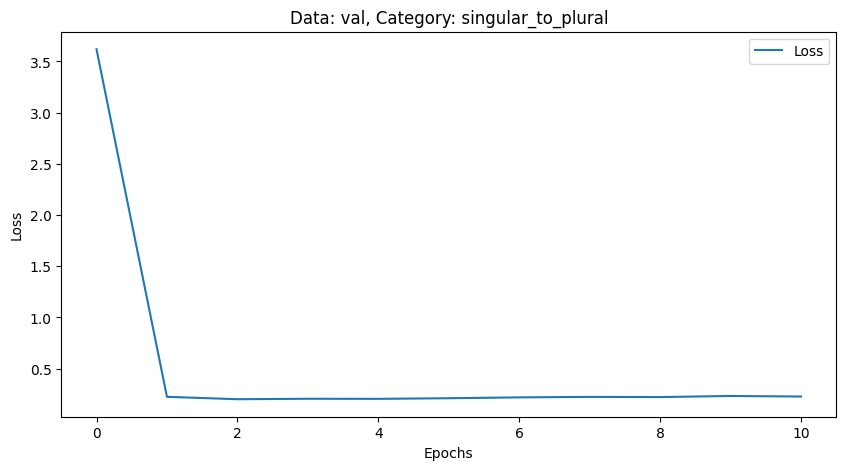

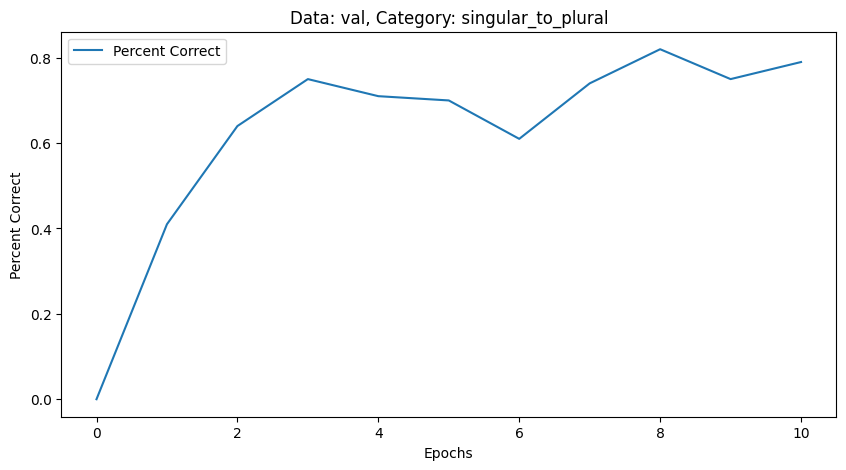

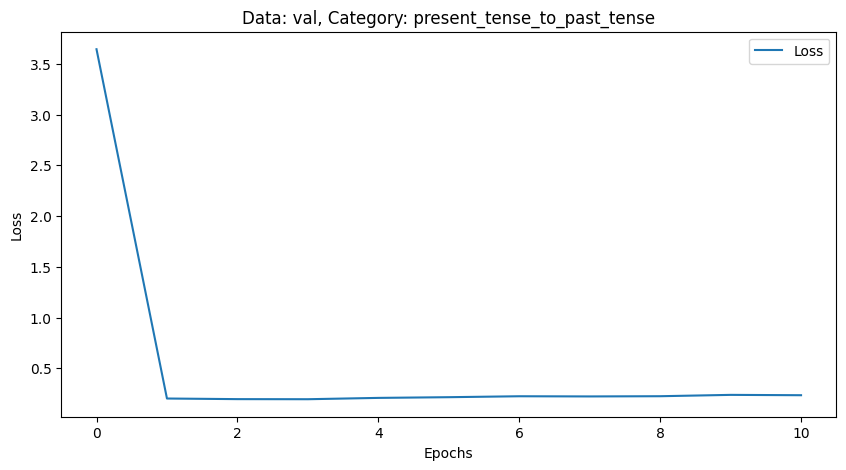

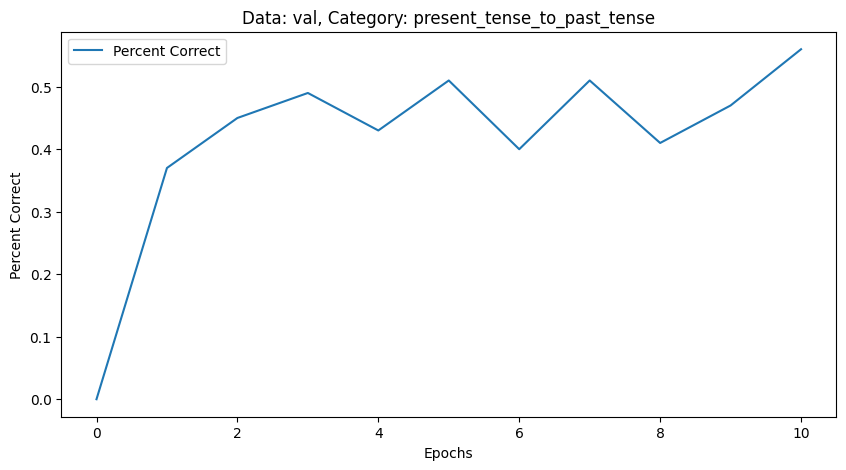

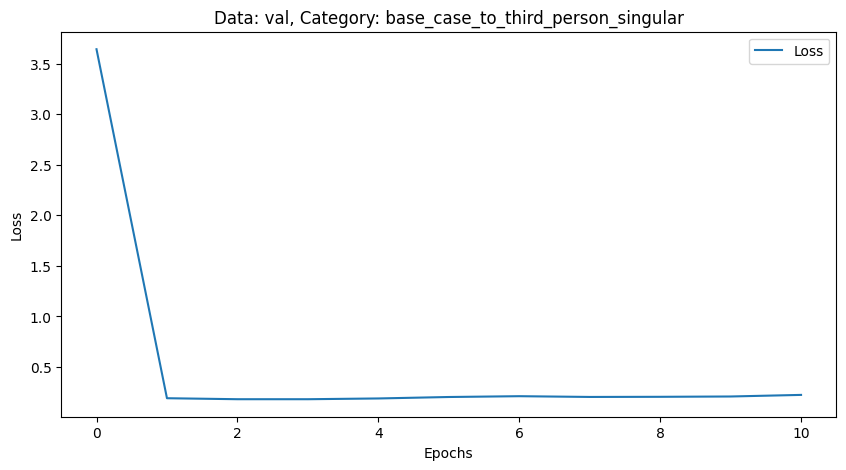

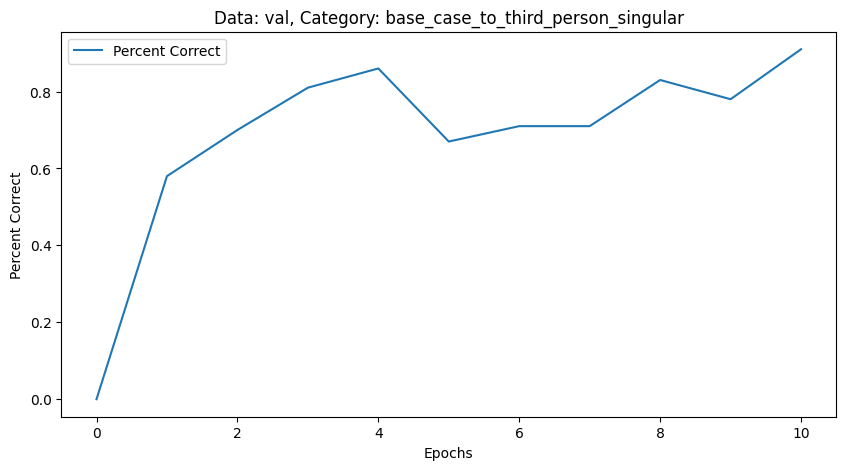

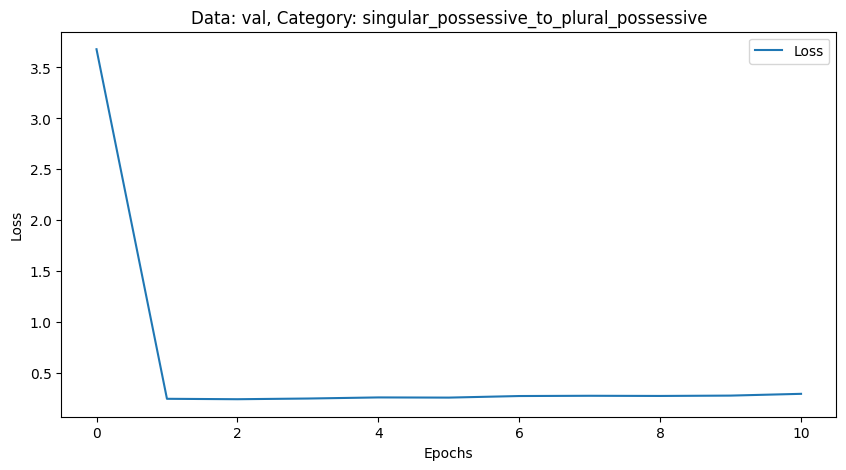

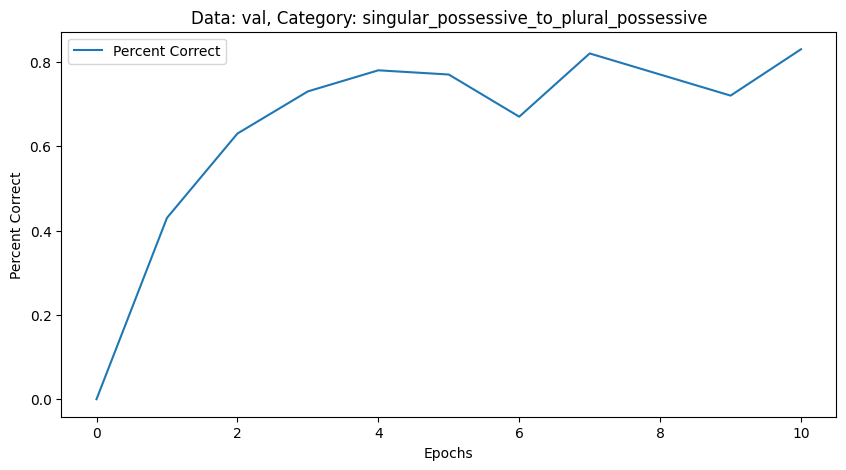

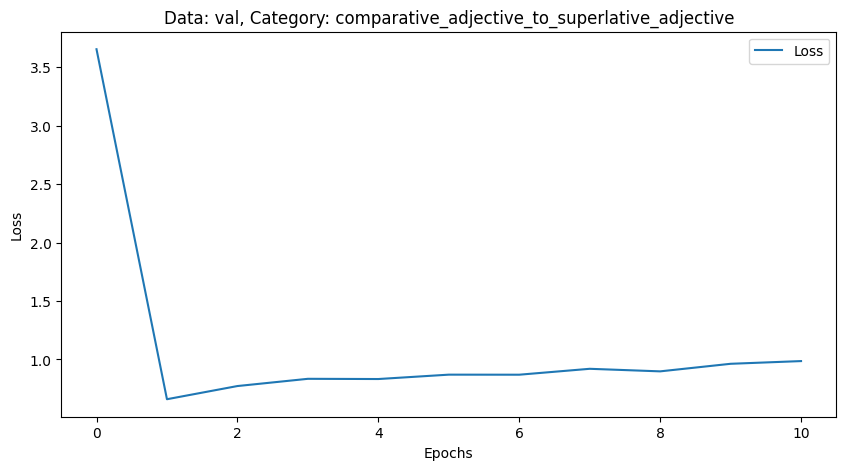

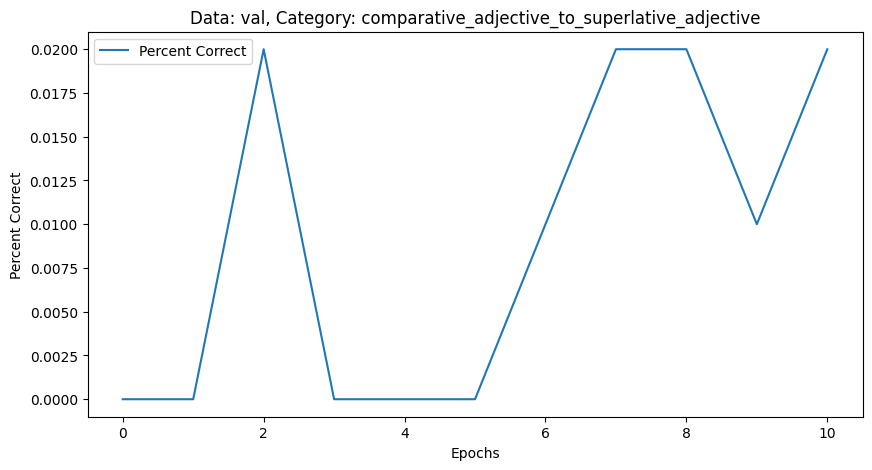

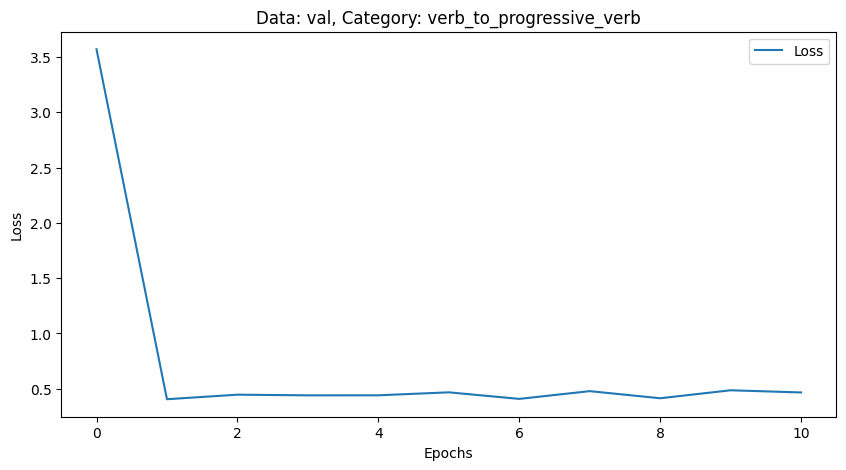

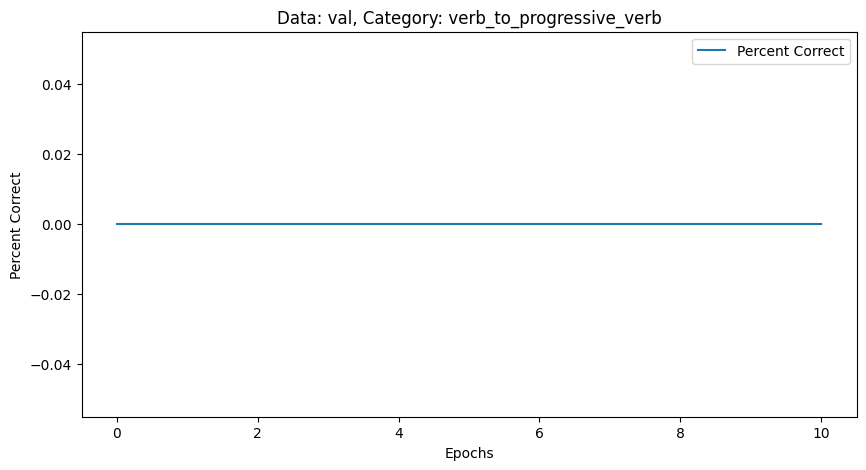

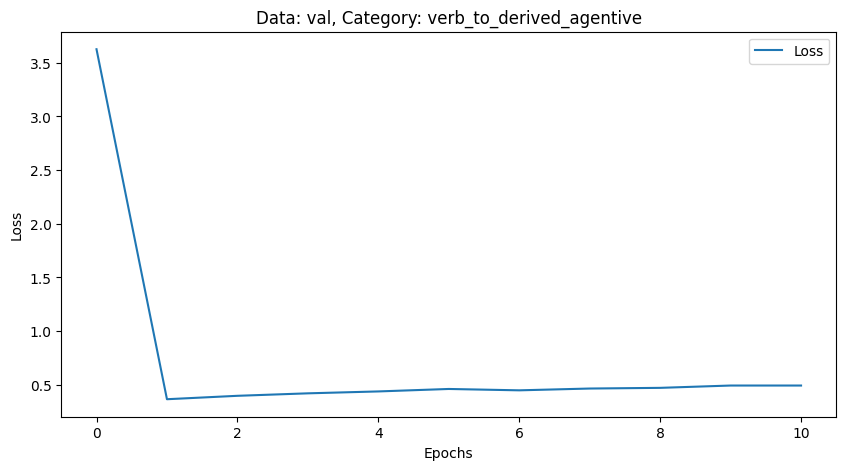

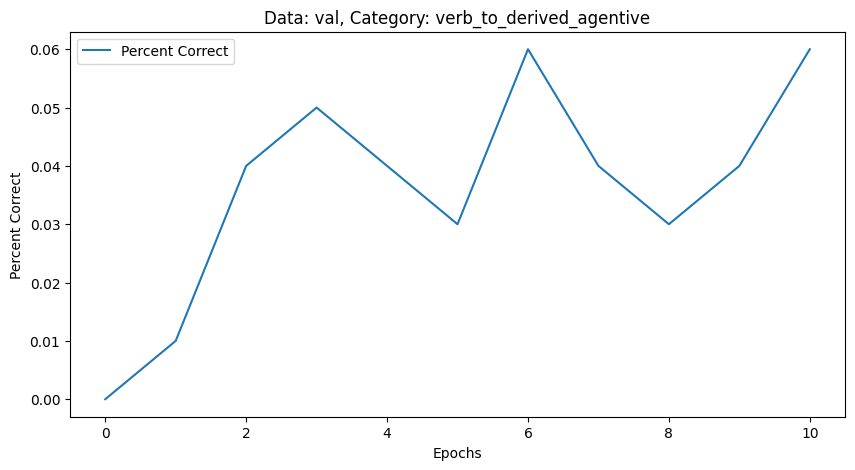

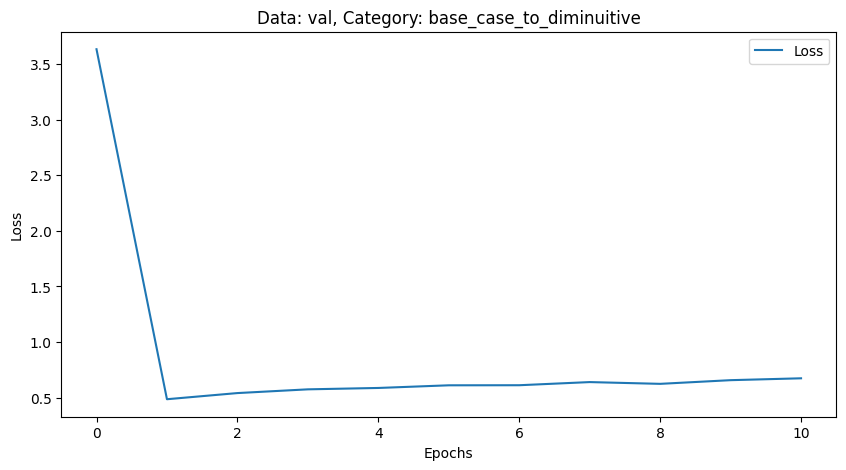

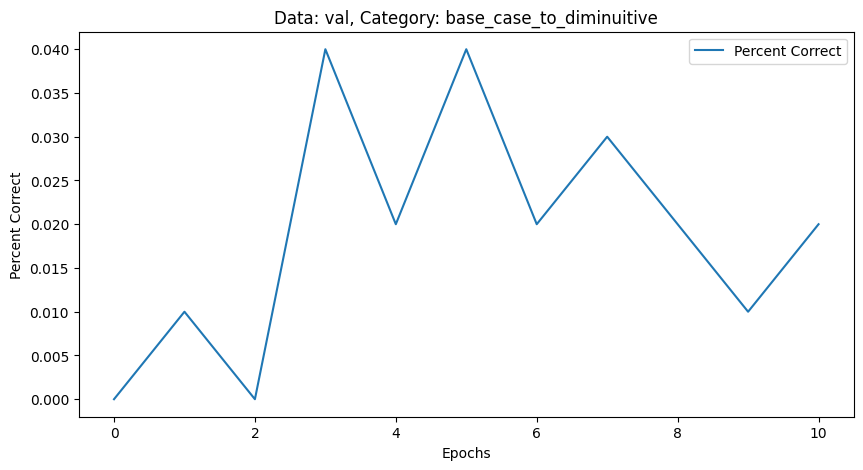

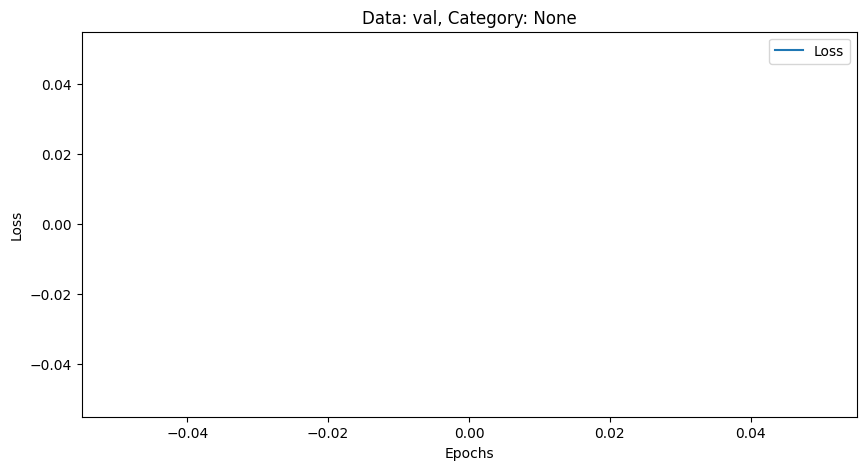

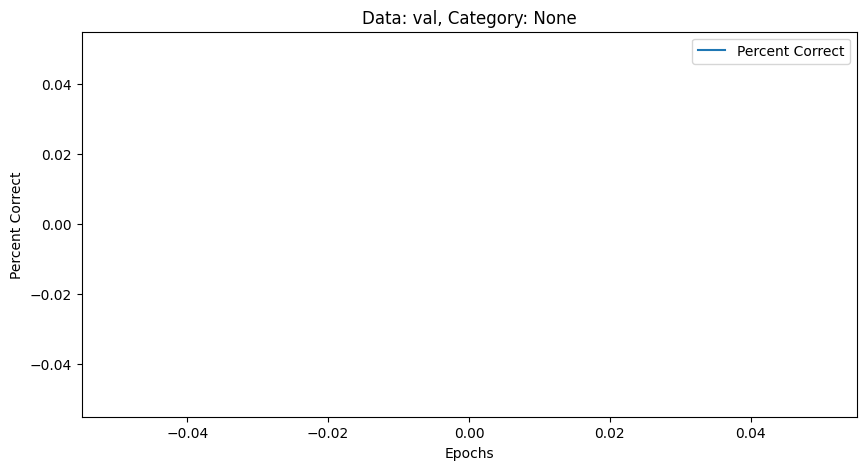

In [13]:
# prompt: losses = {
#     'train': {
#         'singular_to_plural': [],
#         'present_tense_to_past_tense': [],
#         'base_case_to_third_person_singular': [],
#         'singular_possessive_to_plural_possessive': [],
#         None: [],
#     },
#     'val': {
#         "singular_to_plural": [],
#         "present_tense_to_past_tense": [],
#         "base_case_to_third_person_singular": [],
#         "singular_possessive_to_plural_possessive": [],
#         "comparative_adjective_to_superlative_adjective": [],
#         "verb_to_progressive_verb": [],
#         "verb_to_derived_agentive": [],
#         "base_case_to_diminuitive": [],
#         None: [],
#     }
# }
# correctness = {
#     'train': {
#         'singular_to_plural': [],
#         'present_tense_to_past_tense': [],
#         'base_case_to_third_person_singular': [],
#         'singular_possessive_to_plural_possessive': [],
#         None: [],
#     },
#     'val': {
#         "singular_to_plural": [],
#         "present_tense_to_past_tense": [],
#         "base_case_to_third_person_singular": [],
#         "singular_possessive_to_plural_possessive": [],
#         "comparative_adjective_to_superlative_adjective": [],
#         "verb_to_progressive_verb": [],
#         "verb_to_derived_agentive": [],
#         "base_case_to_diminuitive": [],
#         None: [],
#     }
# }
# You are given the losses and correctness dictionaries. Values are appended to the dictionary every EVAL_INTERVAL iterations. For every value in the dictionary, I want you to create a graph using matplotlib. The title should say "Dataset: {data}", either train or test, "Category: {category}, which has multiple values. If the category is None, print the string 'None'. The x axis should say the epochs, and the y axis should say either the loss or the percent correct, depending on whether we are using losses or correctness.

import matplotlib.pyplot as plt

# Assuming losses and correctness dictionaries are defined as in the original code

for dataset_name in ['train', 'val']:
    for category in losses[dataset_name]:
        category_name = category if category is not None else 'None'

        # Plot Losses
        plt.figure(figsize=(10, 5))  # Adjust figure size as needed
        plt.plot(losses[dataset_name][category], label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Data: {dataset_name}, Category: {category_name}')
        plt.legend()
        plt.show()

        # Plot Correctness
        plt.figure(figsize=(10, 5))  # Adjust figure size as needed
        plt.plot(correctness[dataset_name][category], label='Percent Correct')
        plt.xlabel('Epochs')
        plt.ylabel('Percent Correct')
        plt.title(f'Data: {dataset_name}, Category: {category_name}')
        plt.legend()
        plt.show()


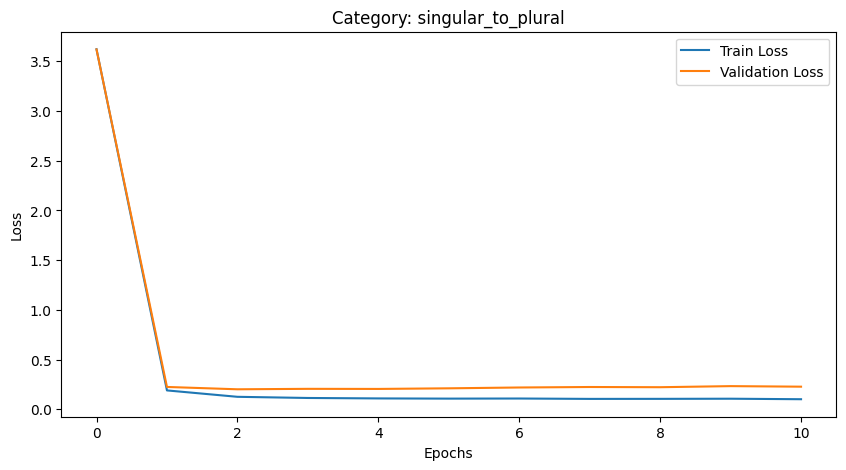

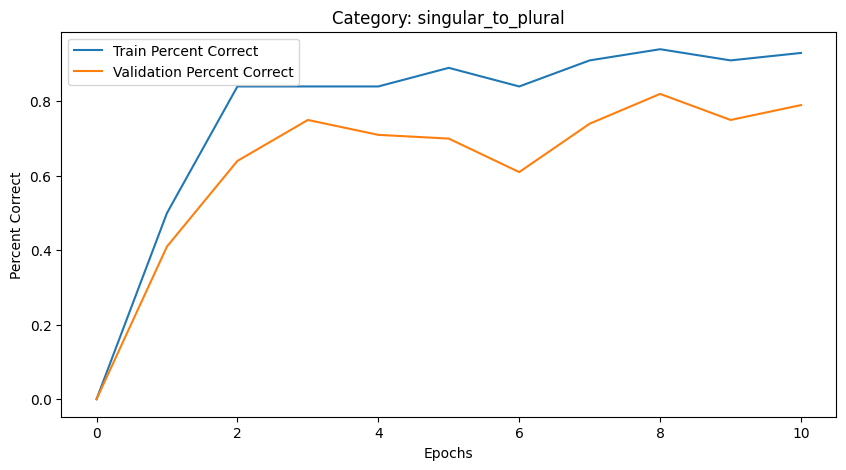

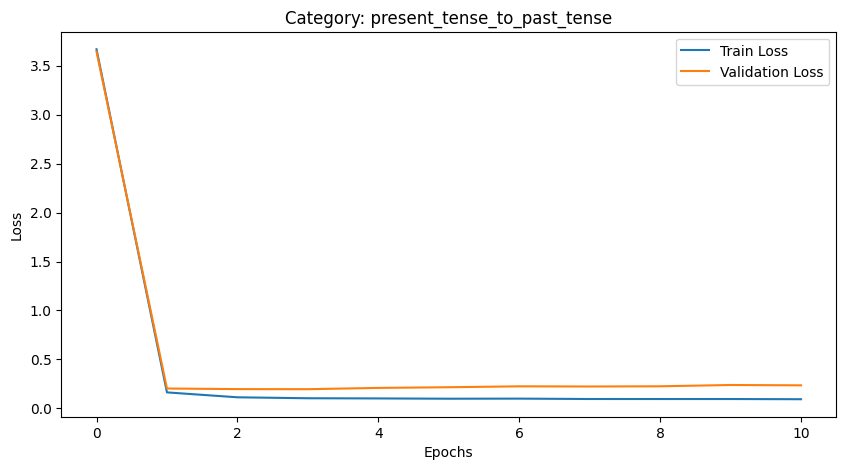

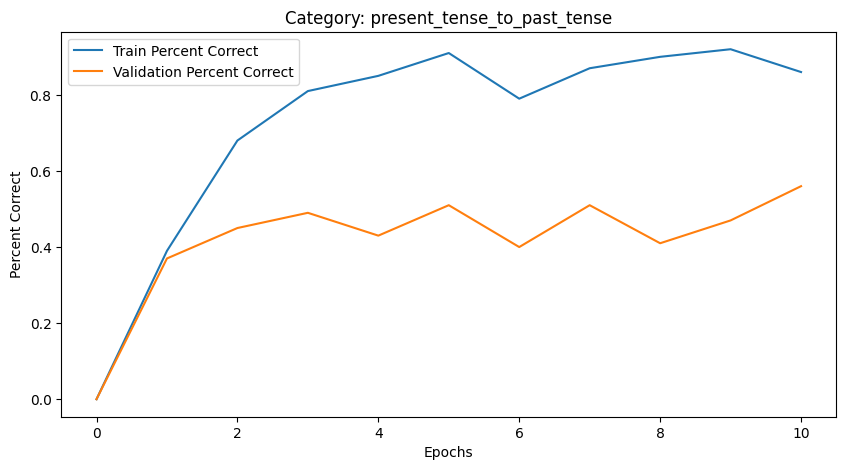

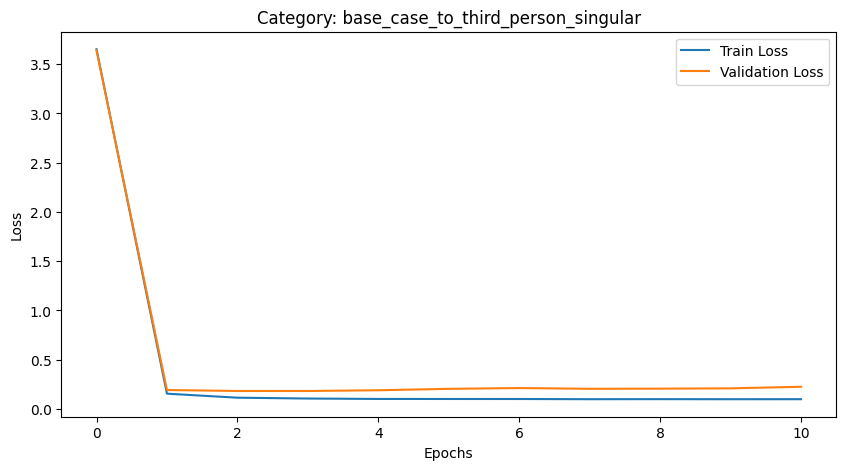

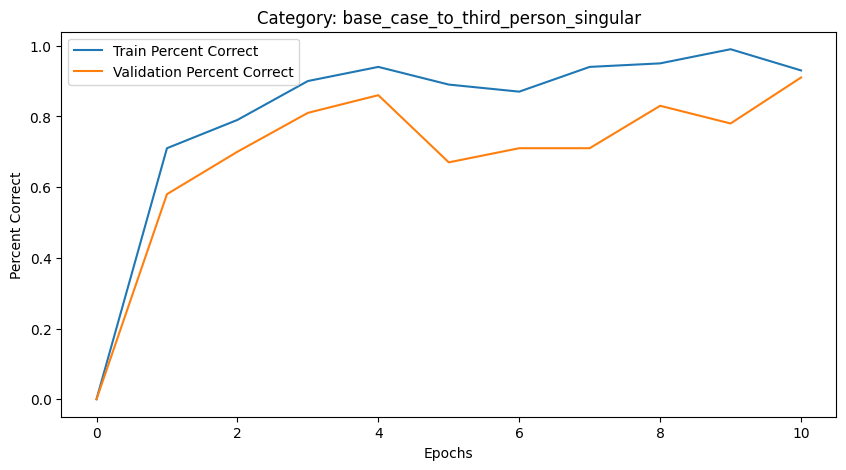

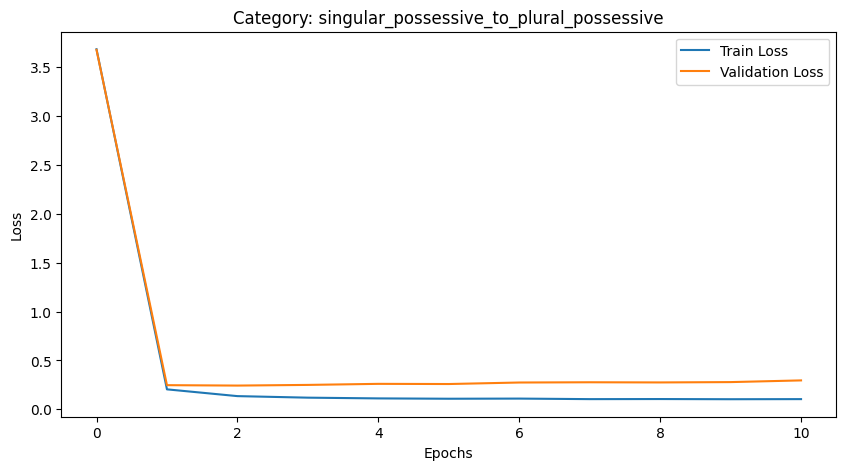

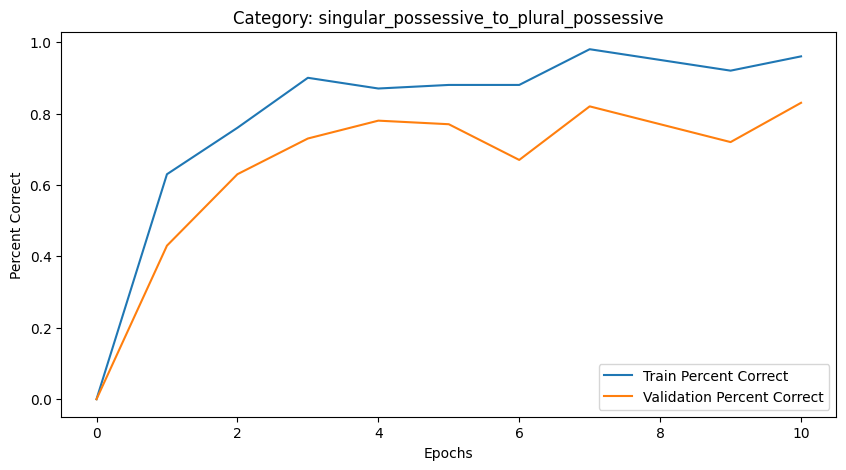

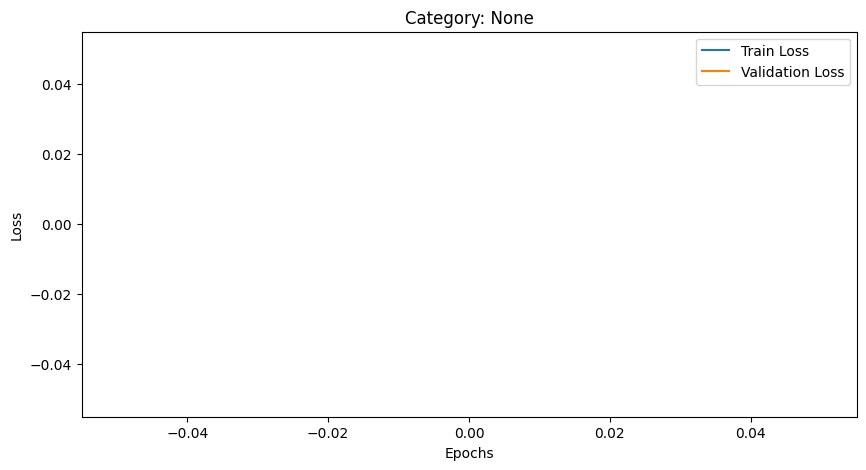

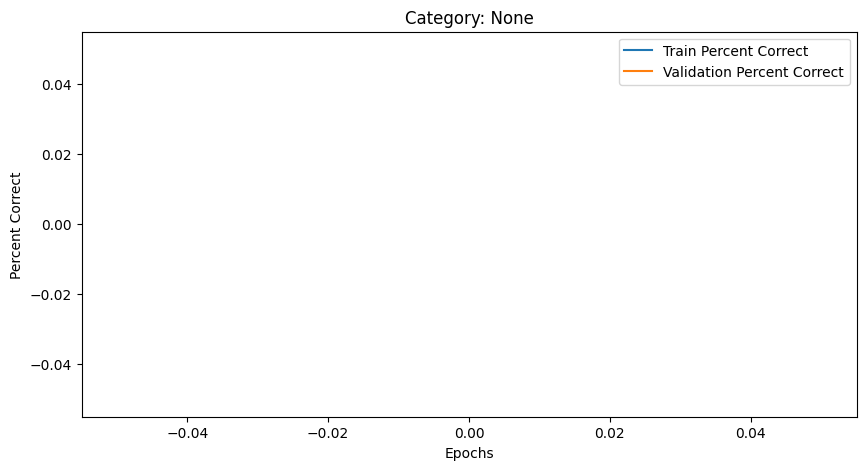

In [14]:
# prompt: import matplotlib.pyplot as plt
# # Assuming losses and correctness dictionaries are defined as in the original code
# for dataset_name in ['train', 'val']:
#     for category in losses[dataset_name]:
#         category_name = category if category is not None else 'None'
#         # Plot Losses
#         plt.figure(figsize=(10, 5))  # Adjust figure size as needed
#         plt.plot(losses[dataset_name][category], label='Loss')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.title(f'Data: {dataset_name}, Category: {category_name}')
#         plt.legend()
#         plt.show()
#         # Plot Correctness
#         plt.figure(figsize=(10, 5))  # Adjust figure size as needed
#         plt.plot(correctness[dataset_name][category], label='Percent Correct')
#         plt.xlabel('Epochs')
#         plt.ylabel('Percent Correct')
#         plt.title(f'Data: {dataset_name}, Category: {category_name}')
#         plt.legend()
#         plt.show()
# Modify this code. For the categories that have both a train and a validation set, plot the train and validation statistics together. For the ones that only have a validation set, plot the validation stuff in orange.

# Assuming losses and correctness dictionaries are defined as in the original code

for category in losses['train']:
    category_name = category if category is not None else 'None'
    if category in losses['val']:
        # Plot Losses
        plt.figure(figsize=(10, 5))  # Adjust figure size as needed
        plt.plot(losses['train'][category], label='Train Loss')
        plt.plot(losses['val'][category], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Category: {category_name}')
        plt.legend()
        plt.show()

        # Plot Correctness
        plt.figure(figsize=(10, 5))  # Adjust figure size as needed
        plt.plot(correctness['train'][category], label='Train Percent Correct')
        plt.plot(correctness['val'][category], label='Validation Percent Correct')
        plt.xlabel('Epochs')
        plt.ylabel('Percent Correct')
        plt.title(f'Category: {category_name}')
        plt.legend()
        plt.show()
    else:
        # Plot Losses (Validation only, in orange)
        plt.figure(figsize=(10, 5))  # Adjust figure size as needed
        plt.plot(losses['val'][category], label='Validation Loss', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Category: {category_name}')
        plt.legend()
        plt.show()

        # Plot Correctness (Validation only, in orange)
        plt.figure(figsize=(10, 5))  # Adjust figure size as needed
        plt.plot(correctness['val'][category], label='Validation Percent Correct', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Percent Correct')
        plt.title(f'Category: {category_name}')
        plt.legend()
        plt.show()
